In [2]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as sg 
from tkinter import *
#import kbhit
# gráficos en el notebook
%matplotlib inline
SRATE = 44100 # Sample rate, para todo el programa
CHUNK = 1024

In [3]:
class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0,shape='sin'):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0
        self.shape = shape

    def next(self):    
        if self.shape=='sin':
            out = np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='square':
            out = sg.square(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='sawtooth':
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='triangle':
            # Ojo, la triangular no existe como tal en scipy, pero podemos hacerla con dos sawtooth
            # el 2º parametro define la "rampa" la subida y bajada (ver documentacion)
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase,0.5)
        self.frame += CHUNK

        return np.float32(self.amp*out)

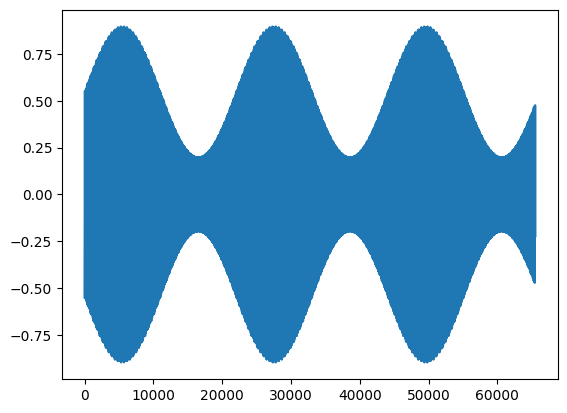

In [8]:
#Ejercicio 1

class Modulator:
    def __init__(self, signal, freq = 1, v0 = 0, v1 = 0):
        self.freq = freq
        self.v0 = v0
        self.v1 = v1
        self.signal = signal

        self.mod = Osc(self.freq)

        self.frame = 0
        

    def next(self):
        out = ((self.v1-self.v0)*self.mod.next()+(self.v1+self.v0))/2
        self.frame += CHUNK
        return out * self.signal.next()

# señal que vamos a modular
signal = Osc(freq=440,shape='triangle')

# con un modulador de 2 Hz y amplitud en [0.2,0.9]
mod = Modulator(signal,freq=2,v0=.2,v1=.9)

# generamos 1.5 segundos de señal modulada
time = 1.5
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

signal = np.empty(0) # acumulador de la señal

for i in range(chunks): # generamos los chunks
    signal = np.append(signal,mod.next())

plt.plot(signal)

sd.play(signal)

sd.wait()
        

129


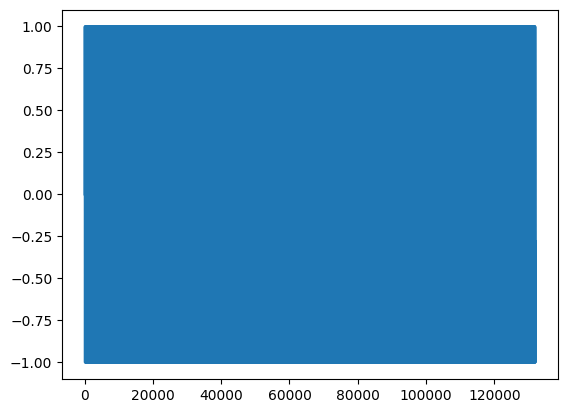

In [10]:
#ejercicio 2

class Osc2:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0,shape='sin'):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0
        self.shape = shape

    def next(self):    
        if self.shape=='sin':
            out = np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='square':
            out = sg.square(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='sawtooth':
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='triangle':
            # Ojo, la triangular no existe como tal en scipy, pero podemos hacerla con dos sawtooth
            # el 2º parametro define la "rampa" la subida y bajada (ver documentacion)
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase,0.5)
        self.frame += CHUNK

        return np.float32(self.amp*out)

    def getAmp(self):
        return self.amp

    def getFreq(self):
        return self.freq

    def setAmp(self, amp):
        self.amp = amp

    def setFreq(self, freq):
        self.freq = freq


signal = Osc2()

# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

print(chunks)

varios = np.zeros(0)
for i in range(chunks):
    varios = np.append(varios,signal.next())

sd.play(varios)

plt.plot(varios)

sd.wait()



In [ ]:
def callback(outdata, frames, time, status):
    varios = np.zeros(0)
    for i in range(chunks):
        varios = np.append(varios,signal.next())
    sd.play(varios)
    sd.wait()

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

# inicialización de la ventanas 
root=Tk()

# Caja de texto
text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"Press 'f/F' to increase and decrease frequency and 'v/V' to increase and decrease volume\n")

# call back para la pulsación de teclas
def key_down(event):

    global signal
    if event.char=='f': 
        signal.setFreq(signal.getFreq() + 110)
    elif event.char == 'F':
        signal.setFreq(signal.getFreq() - 110)
    elif event.char=='v': 
        if signal.getAmp() < 1:
            signal.setAmp(signal.getAmp() + 0.1)
    elif event.char == 'V':
        if signal.getAmp() > 0:
            signal.setAmp(signal.getAmp() - 0.1)
        else:
            signal.setAmp(0)



# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)


# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()

Mas amp
0.40000000000000013
Mas amp
0.5000000000000001
Menos, amp
0.40000000000000013
Menos, amp
0.30000000000000016
Menos, amp
0.20000000000000015
Menos, amp
0.10000000000000014
Menos, amp
1.3877787807814457e-16
Menos, amp
-0.09999999999999987
Menos, amp
0
Menos, amp
0
Mas amp
0.1
Mas amp
0.2
Mas amp
0.30000000000000004
Mas amp
0.4
Mas amp
0.5
Mas amp
0.6
Mas amp
0.7
Mas amp
0.7999999999999999
Mas amp
0.8999999999999999
Mas amp
0.9999999999999999
Mas amp
1.0999999999999999
Mas amp
1.0999999999999999


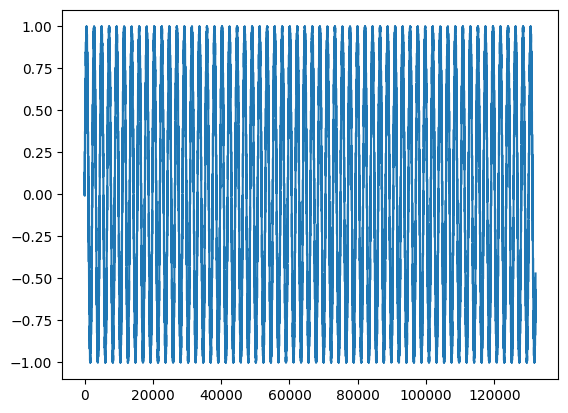

In [4]:
class OscFM:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0

        #Preguntar porque llama a esto moduladora
        # moduladora = βsin(2πfm)
        
    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = Osc(freq=self.fm,amp=self.beta).next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)
        self.frame += CHUNK
        return out 
    
    def getFM(self):
        return self.fm
    
    def getBeta(self):
        return self.beta
    
    def setFM(self, fm):
        self.fm = fm

    def setBeta(self, beta):
        self.beta = beta
    

signal = OscFM(fc=20,fm=1000,beta=0.1)

# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

varios = np.zeros(0)
for i in range(chunks):
    varios = np.append(varios,signal.next())

sd.play(varios)

plt.plot(varios)

sd.wait()

In [5]:
def callback(outdata, frames, time, status):
    s = signal.next()
    outdata[:] = s.reshape(-1, 1)

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

# inicialización de la ventanas 
root=Tk()

# Caja de texto
text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"Press 'm/M' to increase and decrease modular frequency and 'b/B' to increase and decrease beta\n")

# call back para la pulsación de teclas
def key_down(event):

    global signal
    if event.char=='m': 
        signal.setFM(signal.getFM() + 200)
    elif event.char == 'M':
        signal.setFM(signal.getFM() - 200)
    elif event.char=='b': 
        if signal.getBeta() < 1:
            signal.setBeta(signal.getBeta() + 0.1)
    elif event.char == 'B':
        if signal.getBeta() > 0:
            signal.setBeta(signal.getBeta() - 0.1)
        else:
            signal.setBeta(0)



# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)


# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()

In [ ]:
#ejercicio 4

class OscFM_Paneo:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0, paneo=0.5):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0
        self.paneo = paneo

        #Preguntar porque llama a esto moduladora
        # moduladora = βsin(2πfm)
        
    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = Osc(freq=self.fm,amp=self.beta).next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)

        left = out
        right = out

        left = left * np.sqrt((1 - self.paneo))
        right = right * np.sqrt(self.paneo)

        out = np.column_stack((left,right))

        self.frame += CHUNK
        return out 
    
    def getFM(self):
        return self.fm
    
    def getBeta(self):
        return self.beta
    
    def setFM(self, fm):
        self.fm = fm

    def setBeta(self, beta):
        self.beta = beta


signal = OscFM_Paneo(paneo=0.5)

time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

varios = np.zeros([0,2])

for i in range(chunks):
    varios = np.append(varios,signal.next(), axis=0)

print(varios)

sd.play(varios)
sd.wait()

[[ 0.          0.        ]
 [ 0.01168596  0.01168596]
 [ 0.02336873  0.02336873]
 ...
 [-0.43552129 -0.43552129]
 [-0.44450001 -0.44450001]
 [-0.45336145 -0.45336145]]


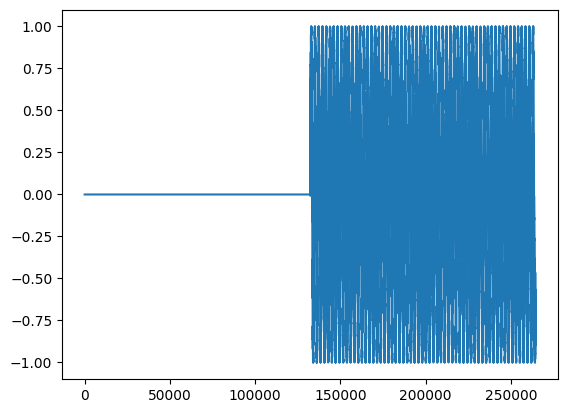

In [8]:
#ejercicio 7

class Delay():

    def __init__(self, time=1):
        self.time = time

    def getDelayedSignal(self, signal):
   
        solution = np.zeros(self.time * SRATE)

        solution = np.append(solution, signal)
        
        return solution

signal = OscFM(fc=20,fm=1000,beta=0.1)

# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

varios = np.zeros(0)
for i in range(chunks):
    varios = np.append(varios,signal.next())

delayedSignal = Delay(3).getDelayedSignal(varios)

sd.play(delayedSignal)

plt.plot(delayedSignal)

sd.wait()

In [11]:
#ejercicio 8

import tkinter as tk

class Theremin(Osc2):
    def __init__(self,freq=440.0,amp=1.0,phase=0.0,shape='sin'):
        
        super().__init__(freq, amp, phase, shape)

        self.minFreq = 50
        self.maxFreq = 1500
        self.minAmp = 0
        self.maxAmp = 1


    def getAmp(self):
        return self.amp

    def getFreq(self):
        return self.freq
    
    def getMaxAmp(self):
        return self.maxAmp
    
    def getMaxFreq(self):
        return self.maxFreq

    def setAmp(self, amp):
        if amp <= self.maxAmp and amp >= self.minAmp:
            self.amp = amp

    def setFreq(self, freq):
        if freq <= self.maxFreq and freq >= self.minFreq:
            self.freq = freq

    
theremin = Theremin()

def callback(outdata, frames, time, status):

    s = theremin.next()
    outdata[:] = s.reshape(-1, 1)
    

stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

WIDTH, HEIGHT = 800, 600
root = tk.Tk()
root.geometry(f"{WIDTH}x{HEIGHT}")

def motion(event):

    global theremin

    x = root.winfo_pointerx()
    y = root.winfo_pointery()
    
    theremin.setAmp((y * theremin.getMaxAmp()) / HEIGHT)
    theremin.setFreq((x * theremin.getMaxFreq()) / WIDTH)

root.bind('<Motion>', motion)

root.mainloop()

stream.stop()
stream.close()

In [ ]:
#Ejercicio 8 extensiones

def myround(x, base=110):
    return base * np.round(x/base)

class ThereminFM(OscFM):
    def __init__(self, posibleFrecuencies, fc=440.0,amp=1.0,fm=6.0, beta=1.0):
        
        super().__init__(fc, amp, fm, beta)

        self.frecuenciesTable = posibleFrecuencies
        self.minFreq = posibleFrecuencies[0]
        self.maxFreq = posibleFrecuencies[-1]

        self.minAmp = 0
        self.maxAmp = 1

    def getAmp(self):
        return self.amp

    def getFreq(self):
        return self.fc
    
    def getMaxAmp(self):
        return self.maxAmp
    
    def getMaxFreq(self):
        return self.maxFreq

    def setAmp(self, amp):
        if amp <= self.maxAmp and amp >= self.minAmp:
            self.amp = amp

    def setFreq(self, freq):
        if freq <= self.maxFreq and freq >= self.minFreq:
            self.fc = myround(freq, 110)

posiblesFrecuencias = np.array([110, 220, 330, 440, 550, 660, 770, 880, 990, 1100, ])

theremin = ThereminFM(posibleFrecuencies=posiblesFrecuencias)

def callback(outdata, frames, time, status):

    s = theremin.next()
    outdata[:] = s.reshape(-1, 1)
    

stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

WIDTH, HEIGHT = 800, 600
root = tk.Tk()
root.geometry(f"{WIDTH}x{HEIGHT}")

def motion(event):

    global theremin

    x = root.winfo_pointerx()
    y = root.winfo_pointery()
    
    theremin.setAmp((y * theremin.getMaxAmp()) / HEIGHT)
    theremin.setFreq((x * theremin.getMaxFreq()) / WIDTH)

root.bind('<Motion>', motion)

root.mainloop()

stream.stop()
stream.close()